## 1. Imports and Code useful Snippets

### 1.1 uncomment to Install Magenta library in the environment

In [ ]:
# !pip install magenta
!pip list

### 1.2 Code block to filter warnings

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### 1.3 Imports

In [ ]:
import sys
import functools
import warnings
import numpy as np
import time
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Magenta Imports
import magenta.music as mm
from magenta.models.music_vae.data import GrooveConverter
from magenta.models.music_vae import configs
from magenta.models.music_vae import data
from magenta.models.music_vae.data import *

#Tensorflow Imports
import tensorflow as tf
#!pip install tensorflow_datasets
import tensorflow_datasets as tfds
print(tf.__version__)

#Enable Eager Execution
tf.enable_eager_execution()

1.15.3


### 1.4 Disable Eager Execution(Uncomment if to run in graph mode)

In [ ]:
# tf.compat.v1.disable_eager_execution()

### 1.5 GPU Accelerator

In [ ]:
# device_name = tf.test.gpu_device_name()
# # if device_name != '/device:GPU:0':
# #   raise SystemError('GPU device not found')
# print(device_name)

## 2. Data Processing Functions

### 2.1 Load available configs for GrooVAE Dataset

In [ ]:
#Load available configurations for available tasks
config_2_bar = configs.CONFIG_MAP['groovae_2bar_humanize']
config_tap_fixed_velocity = configs.CONFIG_MAP['groovae_2bar_tap_fixed_velocity']
config_tap_fixed_velocity_dropout = configs.CONFIG_MAP['groovae_2bar_tap_fixed_velocity_note_dropout']
configs_add_closed_hh = configs.CONFIG_MAP['groovae_2bar_add_closed_hh']
configs_hit_control = configs.CONFIG_MAP['groovae_2bar_hits_control_tfds']

### 2.2 Get Dataset from TFDS and store in a tf.Data Object

In [ ]:

def Initialize_dataset_as_iterator(config, batch_size, is_training=False, cache_dataset=True):

    data_converter = config.data_converter
    data_converter.set_mode('train' if is_training else 'eval')

    tf.logging.info('Reading examples from TFDS: %s',config.tfds_name)
    dataset = tfds.load(
        config.tfds_name,
        split=tfds.Split.TRAIN if is_training else tfds.Split.VALIDATION,
        shuffle_files=is_training,
        try_gcs=False
    )
    
    print("The number of elements is this dataset is: {}".format(tf.compat.v2.data.experimental.cardinality(dataset)))

    # print(dataset)

    midi_to_note = lambda x:[mm.midi_to_note_sequence(x.numpy()).SerializeToString()]

#### FUNCTION 1
    def _tf_midi_to_notesequence(ex):
        return tf.py_function(
            midi_to_note,
            inp = [ex['midi']],
            Tout= tf.string,
            name='midi_to_note_sequence')

####FUNCTION 2
    def _binary_to_decimal_2(inputs,outputs,_,__):
    
      sequence_length = 32
      drum_features = 9
      prev = 0

      inputs = tf.squeeze(inputs)
      outputs = tf.squeeze(outputs)
      
      def binary_logic(x):
        
        result = tf.reduce_sum(
        tf.cast( x, dtype=tf.int64)
        * 2 ** tf.range(tf.cast(tf.size(x), dtype=tf.int64)))
        return result
    
      input_digit = [binary_logic(inputs[i][:9]) for i in range(sequence_length)]
      output_digit = [binary_logic(outputs[i][:9]) for i in range(sequence_length)]

      #If required to return a tensor
      input_tensor_digit = tf.convert_to_tensor(input_digit, dtype=tf.int64)
      output_tensor_digit = tf.convert_to_tensor(output_digit, dtype=tf.int64)

      return input_tensor_digit, output_tensor_digit

#### FUNCTION 3
    def _remove_pad_fn(padded_seq_1, padded_seq_2, padded_seq_3, length):
        if length.shape.ndims == 0:
            return (padded_seq_1[0:length], padded_seq_2[0:length],
                    padded_seq_3[0:length], length)
        else:
            # Don't remove padding for hierarchical examples.
            return padded_seq_1, padded_seq_2, padded_seq_3, length

#### MAP FUNCTION 1
    dataset = (dataset.map(
        _tf_midi_to_notesequence,
        num_parallel_calls=tf.data.experimental.AUTOTUNE))

    # print(dataset)

#### MAP TO TENSORS
    dataset = dataset.map(
      tf.autograph.experimental.do_not_convert(
          functools.partial(convert_to_tensors_op, converter=data_converter)),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)

####
    dataset = dataset.unbatch()


#### MAP FUNCTION 2
    dataset = dataset.map(_binary_to_decimal_2,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

#### MAP FUNCTION3       
    # dataset = dataset.map(
    #   _remove_pad_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # print(dataset)

#### SHUFFLE IF IS_TRAINING
    if is_training:
        dataset =dataset.shuffle(buffer_size=10 * batch_size)


#### MAKE THE DATASET INTO A BATCH
    # dataset = dataset.padded_batch(
    #     1,
    #     dataset.output_shapes,
    #     drop_remainder=True
    # ).prefetch(tf.data.experimental.AUTOTUNE)

    dataset = dataset.padded_batch(
      batch_size,
      tf.data.get_output_shapes(dataset),
      drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)



#### MAKE DATASET AN ITERATOR
    # dataset = iter(dataset)
    
    # print(dataset)

    return dataset

In [ ]:
# val_dataset = Initialize_dataset_as_iterator(configs_add_closed_hh,64)

# train_dataset = Initialize_dataset_as_iterator(configs_add_closed_hh,64,is_training=True)

## 3. Transformer Code

### 3.1 Positional encoding


In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates


def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)


### 3.2 Masking

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)


### 3.3 Attention

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights


In [ ]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

### 3.4 Point wise feed forward layer

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])


### 3.5 Encoder

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2


In [ ]:

class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)


### 3.6 Decoder

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2


In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights


### 3.7 Assemble the transformer

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights


### 3.8 Optimizer

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

# plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
# plt.ylabel("Learning Rate")
# plt.xlabel("Train Step")

### 3.9 Loss

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [ ]:
val_loss = tf.keras.metrics.Mean(name='val_loss')

val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='val_accuracy')

## 4. Training and Experiments

### 4.1 Data Loading

In [ ]:
# tensors = Initialize_dataset_as_iterator(configs_add_closed_hh,64,is_training = True)

### 4.2 Hyperparameters

In [ ]:
num_layers = 2
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = 512 + 2
target_vocab_size = 512 + 2
dropout_rate = 0.25

EPOCHS = 80

### 4.3 Create the Transformer

In [ ]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

### 4.4 Training

In [ ]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask


In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')


In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)


In [ ]:
transformer.call

<bound method Transformer.call of <__main__.Transformer object at 0x7f3fa8f5a438>>

Validation step

In [ ]:
val_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=val_step_signature)
def val_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  

  predictions, _ = transformer(inp, tar_inp, 
                                False, 
                                enc_padding_mask, 
                                combined_mask, 
                                dec_padding_mask)
  loss = loss_function(tar_real, predictions)
  
  val_loss(loss)
  val_accuracy(tar_real, predictions)


Train Loop

In [ ]:
loss = []
val_Loss = []
for epoch in range(EPOCHS):

  import os
  os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
  start = time.time()

  loss.append(train_loss.result().numpy())
  val_Loss.append(val_loss.result().numpy())
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  train_dataset = Initialize_dataset_as_iterator(configs_add_closed_hh,64,is_training = True)
  val_dataset = Initialize_dataset_as_iterator(configs_add_closed_hh,64)

  for (batch,(inp,tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))

  for (batch,(inp,tar)) in enumerate(val_dataset):
    val_step(inp, tar)
    if batch % 50 == 0:
      print ('Validation: Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, val_loss.result(), val_accuracy.result()))
  

  if (epoch + 1) % 2 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
    
  

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 1 Batch 0 Loss 6.2847 Accuracy 0.0005
Epoch 1 Batch 50 Loss 6.1369 Accuracy 0.0031
Epoch 1 Batch 100 Loss 5.8467 Accuracy 0.0480
Epoch 1 Batch 150 Loss 5.5312 Accuracy 0.0858
Epoch 1 Batch 200 Loss 5.2671 Accuracy 0.1047
Epoch 1 Batch 250 Loss 5.0437 Accuracy 0.1167
Validation: Epoch 1 Batch 0 Loss 3.5928 Accuracy 0.2147
Epoch 1 Loss 5.0225 Accuracy 0.1181
Time taken for 1 epoch: 235.01060366630554 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 2 Batch 0 Loss 3.8843 Accuracy 0.1981
Epoch 2 Batch 50 Loss 3.7836 Accuracy 0.2033
Epoch 2 Batch 100 Loss 3.6314 Accuracy 0.2159
Epoch 2 Batch 150 Loss 3.4984 Accuracy 0.2202
Epoch 2 Batch 200 Loss 3.3746 Accuracy 0.2231
Epoch 2 Batch 250 Loss 3.2623 Accuracy 0.2260
Validation: Epoch 2 Batch 0 Loss 2.3630 Accuracy 0.2692
Saving checkpoint for epoch 2 at ./checkpoints/train/ckpt-1
Epoch 2 Loss 3.2527 Accuracy 0.2259
Time taken for 1 epoch: 222.9841480255127 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 3 Batch 0 Loss 2.7064 Accuracy 0.2651
Epoch 3 Batch 50 Loss 2.6393 Accuracy 0.2436
Epoch 3 Batch 100 Loss 2.5680 Accuracy 0.2488
Epoch 3 Batch 150 Loss 2.5103 Accuracy 0.2516
Epoch 3 Batch 200 Loss 2.4572 Accuracy 0.2547
Epoch 3 Batch 250 Loss 2.4129 Accuracy 0.2568
Validation: Epoch 3 Batch 0 Loss 1.9337 Accuracy 0.3191
Epoch 3 Loss 2.4096 Accuracy 0.2569
Time taken for 1 epoch: 226.29851651191711 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 4 Batch 0 Loss 2.1864 Accuracy 0.2787
Epoch 4 Batch 50 Loss 2.1708 Accuracy 0.2727
Epoch 4 Batch 100 Loss 2.1412 Accuracy 0.2763
Epoch 4 Batch 150 Loss 2.1202 Accuracy 0.2780
Epoch 4 Batch 200 Loss 2.0951 Accuracy 0.2807
Epoch 4 Batch 250 Loss 2.0741 Accuracy 0.2828
Validation: Epoch 4 Batch 0 Loss 1.7399 Accuracy 0.3382
Saving checkpoint for epoch 4 at ./checkpoints/train/ckpt-2
Epoch 4 Loss 2.0719 Accuracy 0.2832
Time taken for 1 epoch: 226.02564072608948 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 5 Batch 0 Loss 1.9935 Accuracy 0.3039
Epoch 5 Batch 50 Loss 1.9342 Accuracy 0.3001
Epoch 5 Batch 100 Loss 1.9164 Accuracy 0.3036
Epoch 5 Batch 150 Loss 1.8990 Accuracy 0.3058
Epoch 5 Batch 200 Loss 1.8783 Accuracy 0.3083
Epoch 5 Batch 250 Loss 1.8541 Accuracy 0.3122
Validation: Epoch 5 Batch 0 Loss 1.4592 Accuracy 0.3891
Epoch 5 Loss 1.8528 Accuracy 0.3123
Time taken for 1 epoch: 224.35000777244568 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 6 Batch 0 Loss 1.7898 Accuracy 0.3301
Epoch 6 Batch 50 Loss 1.7123 Accuracy 0.3335
Epoch 6 Batch 100 Loss 1.6777 Accuracy 0.3414
Epoch 6 Batch 150 Loss 1.6470 Accuracy 0.3473
Epoch 6 Batch 200 Loss 1.6097 Accuracy 0.3535
Epoch 6 Batch 250 Loss 1.5720 Accuracy 0.3609
Validation: Epoch 6 Batch 0 Loss 1.0623 Accuracy 0.4768
Saving checkpoint for epoch 6 at ./checkpoints/train/ckpt-3
Epoch 6 Loss 1.5680 Accuracy 0.3619
Time taken for 1 epoch: 225.05543088912964 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 7 Batch 0 Loss 1.3968 Accuracy 0.3805
Epoch 7 Batch 50 Loss 1.3280 Accuracy 0.4101
Epoch 7 Batch 100 Loss 1.2827 Accuracy 0.4222
Epoch 7 Batch 150 Loss 1.2434 Accuracy 0.4297
Epoch 7 Batch 200 Loss 1.2033 Accuracy 0.4372
Epoch 7 Batch 250 Loss 1.1655 Accuracy 0.4449
Validation: Epoch 7 Batch 0 Loss 0.7432 Accuracy 0.5605
Epoch 7 Loss 1.1618 Accuracy 0.4457
Time taken for 1 epoch: 226.06606602668762 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 8 Batch 0 Loss 0.9980 Accuracy 0.4808
Epoch 8 Batch 50 Loss 0.9588 Accuracy 0.4914
Epoch 8 Batch 100 Loss 0.9325 Accuracy 0.4985
Epoch 8 Batch 150 Loss 0.9085 Accuracy 0.5042
Epoch 8 Batch 200 Loss 0.8860 Accuracy 0.5071
Epoch 8 Batch 250 Loss 0.8655 Accuracy 0.5116
Validation: Epoch 8 Batch 0 Loss 0.5892 Accuracy 0.6048
Saving checkpoint for epoch 8 at ./checkpoints/train/ckpt-4
Epoch 8 Loss 0.8633 Accuracy 0.5119
Time taken for 1 epoch: 225.05215167999268 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 9 Batch 0 Loss 0.7419 Accuracy 0.5348
Epoch 9 Batch 50 Loss 0.7534 Accuracy 0.5389
Epoch 9 Batch 100 Loss 0.7380 Accuracy 0.5436
Epoch 9 Batch 150 Loss 0.7226 Accuracy 0.5474
Epoch 9 Batch 200 Loss 0.7094 Accuracy 0.5493
Epoch 9 Batch 250 Loss 0.6972 Accuracy 0.5513
Validation: Epoch 9 Batch 0 Loss 0.5671 Accuracy 0.6079
Epoch 9 Loss 0.6963 Accuracy 0.5518
Time taken for 1 epoch: 225.05846691131592 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 10 Batch 0 Loss 0.6414 Accuracy 0.5625
Epoch 10 Batch 50 Loss 0.6332 Accuracy 0.5705
Epoch 10 Batch 100 Loss 0.6237 Accuracy 0.5740
Epoch 10 Batch 150 Loss 0.6151 Accuracy 0.5754
Epoch 10 Batch 200 Loss 0.6043 Accuracy 0.5764
Epoch 10 Batch 250 Loss 0.5954 Accuracy 0.5786
Validation: Epoch 10 Batch 0 Loss 0.4807 Accuracy 0.6310
Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-5
Epoch 10 Loss 0.5945 Accuracy 0.5788
Time taken for 1 epoch: 225.62926411628723 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 11 Batch 0 Loss 0.5969 Accuracy 0.5575
Epoch 11 Batch 50 Loss 0.5412 Accuracy 0.5965
Epoch 11 Batch 100 Loss 0.5323 Accuracy 0.5994
Epoch 11 Batch 150 Loss 0.5282 Accuracy 0.6004
Epoch 11 Batch 200 Loss 0.5213 Accuracy 0.6007
Epoch 11 Batch 250 Loss 0.5144 Accuracy 0.6018
Validation: Epoch 11 Batch 0 Loss 0.4313 Accuracy 0.6482
Epoch 11 Loss 0.5142 Accuracy 0.6020
Time taken for 1 epoch: 225.08886694908142 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 12 Batch 0 Loss 0.4763 Accuracy 0.6094
Epoch 12 Batch 50 Loss 0.4776 Accuracy 0.6124
Epoch 12 Batch 100 Loss 0.4710 Accuracy 0.6173
Epoch 12 Batch 150 Loss 0.4660 Accuracy 0.6191
Epoch 12 Batch 200 Loss 0.4592 Accuracy 0.6188
Epoch 12 Batch 250 Loss 0.4527 Accuracy 0.6203
Validation: Epoch 12 Batch 0 Loss 0.3915 Accuracy 0.6598
Saving checkpoint for epoch 12 at ./checkpoints/train/ckpt-6
Epoch 12 Loss 0.4522 Accuracy 0.6201
Time taken for 1 epoch: 225.65525579452515 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 13 Batch 0 Loss 0.3962 Accuracy 0.6482
Epoch 13 Batch 50 Loss 0.4219 Accuracy 0.6294
Epoch 13 Batch 100 Loss 0.4212 Accuracy 0.6336
Epoch 13 Batch 150 Loss 0.4173 Accuracy 0.6328
Epoch 13 Batch 200 Loss 0.4121 Accuracy 0.6328
Epoch 13 Batch 250 Loss 0.4082 Accuracy 0.6329
Validation: Epoch 13 Batch 0 Loss 0.3663 Accuracy 0.6658
Epoch 13 Loss 0.4077 Accuracy 0.6331
Time taken for 1 epoch: 226.32786059379578 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 14 Batch 0 Loss 0.3490 Accuracy 0.5993
Epoch 14 Batch 50 Loss 0.3848 Accuracy 0.6418
Epoch 14 Batch 100 Loss 0.3843 Accuracy 0.6439
Epoch 14 Batch 150 Loss 0.3810 Accuracy 0.6435
Epoch 14 Batch 200 Loss 0.3771 Accuracy 0.6429
Epoch 14 Batch 250 Loss 0.3751 Accuracy 0.6427
Validation: Epoch 14 Batch 0 Loss 0.3423 Accuracy 0.6689
Saving checkpoint for epoch 14 at ./checkpoints/train/ckpt-7
Epoch 14 Loss 0.3753 Accuracy 0.6423
Time taken for 1 epoch: 228.98754453659058 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 15 Batch 0 Loss 0.3051 Accuracy 0.6109
Epoch 15 Batch 50 Loss 0.3616 Accuracy 0.6475
Epoch 15 Batch 100 Loss 0.3579 Accuracy 0.6501
Epoch 15 Batch 150 Loss 0.3542 Accuracy 0.6509
Epoch 15 Batch 200 Loss 0.3519 Accuracy 0.6486
Epoch 15 Batch 250 Loss 0.3495 Accuracy 0.6491
Validation: Epoch 15 Batch 0 Loss 0.3328 Accuracy 0.6724
Epoch 15 Loss 0.3491 Accuracy 0.6491
Time taken for 1 epoch: 228.10313320159912 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 16 Batch 0 Loss 0.2866 Accuracy 0.6598
Epoch 16 Batch 50 Loss 0.3451 Accuracy 0.6525
Epoch 16 Batch 100 Loss 0.3384 Accuracy 0.6554
Epoch 16 Batch 150 Loss 0.3358 Accuracy 0.6556
Epoch 16 Batch 200 Loss 0.3332 Accuracy 0.6541
Epoch 16 Batch 250 Loss 0.3321 Accuracy 0.6542
Validation: Epoch 16 Batch 0 Loss 0.3573 Accuracy 0.6648
Saving checkpoint for epoch 16 at ./checkpoints/train/ckpt-8
Epoch 16 Loss 0.3321 Accuracy 0.6541
Time taken for 1 epoch: 229.3412573337555 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 17 Batch 0 Loss 0.3091 Accuracy 0.6623
Epoch 17 Batch 50 Loss 0.3221 Accuracy 0.6557
Epoch 17 Batch 100 Loss 0.3228 Accuracy 0.6588
Epoch 17 Batch 150 Loss 0.3203 Accuracy 0.6596
Epoch 17 Batch 200 Loss 0.3190 Accuracy 0.6581
Epoch 17 Batch 250 Loss 0.3167 Accuracy 0.6579
Validation: Epoch 17 Batch 0 Loss 0.3550 Accuracy 0.6714
Epoch 17 Loss 0.3169 Accuracy 0.6580
Time taken for 1 epoch: 227.206533908844 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 18 Batch 0 Loss 0.2845 Accuracy 0.6416
Epoch 18 Batch 50 Loss 0.3160 Accuracy 0.6585
Epoch 18 Batch 100 Loss 0.3104 Accuracy 0.6636
Epoch 18 Batch 150 Loss 0.3091 Accuracy 0.6622
Epoch 18 Batch 200 Loss 0.3055 Accuracy 0.6614
Epoch 18 Batch 250 Loss 0.3038 Accuracy 0.6613
Validation: Epoch 18 Batch 0 Loss 0.3159 Accuracy 0.6759
Saving checkpoint for epoch 18 at ./checkpoints/train/ckpt-9
Epoch 18 Loss 0.3040 Accuracy 0.6613
Time taken for 1 epoch: 227.1257073879242 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 19 Batch 0 Loss 0.2911 Accuracy 0.6578
Epoch 19 Batch 50 Loss 0.2956 Accuracy 0.6648
Epoch 19 Batch 100 Loss 0.2970 Accuracy 0.6670
Epoch 19 Batch 150 Loss 0.2950 Accuracy 0.6667
Epoch 19 Batch 200 Loss 0.2930 Accuracy 0.6655
Epoch 19 Batch 250 Loss 0.2922 Accuracy 0.6648
Validation: Epoch 19 Batch 0 Loss 0.3319 Accuracy 0.6739
Epoch 19 Loss 0.2926 Accuracy 0.6647
Time taken for 1 epoch: 226.48089599609375 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 20 Batch 0 Loss 0.2980 Accuracy 0.6411
Epoch 20 Batch 50 Loss 0.2890 Accuracy 0.6670
Epoch 20 Batch 100 Loss 0.2890 Accuracy 0.6692
Epoch 20 Batch 150 Loss 0.2872 Accuracy 0.6688
Epoch 20 Batch 200 Loss 0.2851 Accuracy 0.6677
Epoch 20 Batch 250 Loss 0.2840 Accuracy 0.6672
Validation: Epoch 20 Batch 0 Loss 0.3217 Accuracy 0.6890
Saving checkpoint for epoch 20 at ./checkpoints/train/ckpt-10
Epoch 20 Loss 0.2846 Accuracy 0.6668
Time taken for 1 epoch: 225.20926523208618 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 21 Batch 0 Loss 0.2789 Accuracy 0.6532
Epoch 21 Batch 50 Loss 0.2818 Accuracy 0.6686
Epoch 21 Batch 100 Loss 0.2802 Accuracy 0.6722
Epoch 21 Batch 150 Loss 0.2794 Accuracy 0.6712
Epoch 21 Batch 200 Loss 0.2772 Accuracy 0.6700
Epoch 21 Batch 250 Loss 0.2778 Accuracy 0.6688
Validation: Epoch 21 Batch 0 Loss 0.3332 Accuracy 0.6754
Epoch 21 Loss 0.2780 Accuracy 0.6688
Time taken for 1 epoch: 224.12966394424438 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 22 Batch 0 Loss 0.2913 Accuracy 0.6613
Epoch 22 Batch 50 Loss 0.2727 Accuracy 0.6701
Epoch 22 Batch 100 Loss 0.2730 Accuracy 0.6716
Epoch 22 Batch 150 Loss 0.2723 Accuracy 0.6722
Epoch 22 Batch 200 Loss 0.2710 Accuracy 0.6711
Epoch 22 Batch 250 Loss 0.2707 Accuracy 0.6703
Validation: Epoch 22 Batch 0 Loss 0.3369 Accuracy 0.6749
Saving checkpoint for epoch 22 at ./checkpoints/train/ckpt-11
Epoch 22 Loss 0.2709 Accuracy 0.6702
Time taken for 1 epoch: 224.81525802612305 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 23 Batch 0 Loss 0.2748 Accuracy 0.6855
Epoch 23 Batch 50 Loss 0.2657 Accuracy 0.6722
Epoch 23 Batch 100 Loss 0.2663 Accuracy 0.6761
Epoch 23 Batch 150 Loss 0.2644 Accuracy 0.6747
Epoch 23 Batch 200 Loss 0.2638 Accuracy 0.6732
Epoch 23 Batch 250 Loss 0.2641 Accuracy 0.6723
Validation: Epoch 23 Batch 0 Loss 0.3149 Accuracy 0.6850
Epoch 23 Loss 0.2641 Accuracy 0.6722
Time taken for 1 epoch: 223.49860215187073 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 24 Batch 0 Loss 0.2674 Accuracy 0.6557
Epoch 24 Batch 50 Loss 0.2638 Accuracy 0.6731
Epoch 24 Batch 100 Loss 0.2602 Accuracy 0.6766
Epoch 24 Batch 150 Loss 0.2610 Accuracy 0.6750
Epoch 24 Batch 200 Loss 0.2590 Accuracy 0.6737
Epoch 24 Batch 250 Loss 0.2589 Accuracy 0.6735
Validation: Epoch 24 Batch 0 Loss 0.3252 Accuracy 0.6865
Saving checkpoint for epoch 24 at ./checkpoints/train/ckpt-12
Epoch 24 Loss 0.2585 Accuracy 0.6736
Time taken for 1 epoch: 223.83625960350037 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 25 Batch 0 Loss 0.2693 Accuracy 0.6769
Epoch 25 Batch 50 Loss 0.2625 Accuracy 0.6714
Epoch 25 Batch 100 Loss 0.2588 Accuracy 0.6769
Epoch 25 Batch 150 Loss 0.2575 Accuracy 0.6761
Epoch 25 Batch 200 Loss 0.2563 Accuracy 0.6753
Epoch 25 Batch 250 Loss 0.2560 Accuracy 0.6743
Validation: Epoch 25 Batch 0 Loss 0.3271 Accuracy 0.6764
Epoch 25 Loss 0.2558 Accuracy 0.6746
Time taken for 1 epoch: 225.2371175289154 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 26 Batch 0 Loss 0.2421 Accuracy 0.6875
Epoch 26 Batch 50 Loss 0.2549 Accuracy 0.6745
Epoch 26 Batch 100 Loss 0.2557 Accuracy 0.6783
Epoch 26 Batch 150 Loss 0.2527 Accuracy 0.6782
Epoch 26 Batch 200 Loss 0.2512 Accuracy 0.6766
Epoch 26 Batch 250 Loss 0.2518 Accuracy 0.6755
Validation: Epoch 26 Batch 0 Loss 0.3128 Accuracy 0.6809
Saving checkpoint for epoch 26 at ./checkpoints/train/ckpt-13
Epoch 26 Loss 0.2523 Accuracy 0.6752
Time taken for 1 epoch: 223.2407205104828 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 27 Batch 0 Loss 0.2525 Accuracy 0.7006
Epoch 27 Batch 50 Loss 0.2512 Accuracy 0.6773
Epoch 27 Batch 100 Loss 0.2500 Accuracy 0.6800
Epoch 27 Batch 150 Loss 0.2503 Accuracy 0.6788
Epoch 27 Batch 200 Loss 0.2488 Accuracy 0.6771
Epoch 27 Batch 250 Loss 0.2484 Accuracy 0.6767
Validation: Epoch 27 Batch 0 Loss 0.3205 Accuracy 0.6860
Epoch 27 Loss 0.2484 Accuracy 0.6764
Time taken for 1 epoch: 224.45982694625854 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 28 Batch 0 Loss 0.2173 Accuracy 0.6850
Epoch 28 Batch 50 Loss 0.2462 Accuracy 0.6768
Epoch 28 Batch 100 Loss 0.2490 Accuracy 0.6794
Epoch 28 Batch 150 Loss 0.2473 Accuracy 0.6798
Epoch 28 Batch 200 Loss 0.2456 Accuracy 0.6779
Epoch 28 Batch 250 Loss 0.2454 Accuracy 0.6770
Validation: Epoch 28 Batch 0 Loss 0.3164 Accuracy 0.6875
Saving checkpoint for epoch 28 at ./checkpoints/train/ckpt-14
Epoch 28 Loss 0.2450 Accuracy 0.6774
Time taken for 1 epoch: 223.79877924919128 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 29 Batch 0 Loss 0.2774 Accuracy 0.6835
Epoch 29 Batch 50 Loss 0.2436 Accuracy 0.6780
Epoch 29 Batch 100 Loss 0.2438 Accuracy 0.6810
Epoch 29 Batch 150 Loss 0.2448 Accuracy 0.6804
Epoch 29 Batch 200 Loss 0.2426 Accuracy 0.6781
Epoch 29 Batch 250 Loss 0.2429 Accuracy 0.6782
Validation: Epoch 29 Batch 0 Loss 0.3237 Accuracy 0.6840
Epoch 29 Loss 0.2430 Accuracy 0.6781
Time taken for 1 epoch: 222.30528807640076 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 30 Batch 0 Loss 0.2229 Accuracy 0.6905
Epoch 30 Batch 50 Loss 0.2423 Accuracy 0.6791
Epoch 30 Batch 100 Loss 0.2410 Accuracy 0.6804
Epoch 30 Batch 150 Loss 0.2403 Accuracy 0.6810
Epoch 30 Batch 200 Loss 0.2387 Accuracy 0.6793
Epoch 30 Batch 250 Loss 0.2389 Accuracy 0.6785
Validation: Epoch 30 Batch 0 Loss 0.3128 Accuracy 0.6860
Saving checkpoint for epoch 30 at ./checkpoints/train/ckpt-15
Epoch 30 Loss 0.2390 Accuracy 0.6787
Time taken for 1 epoch: 222.82980680465698 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 31 Batch 0 Loss 0.2389 Accuracy 0.6426
Epoch 31 Batch 50 Loss 0.2397 Accuracy 0.6802
Epoch 31 Batch 100 Loss 0.2385 Accuracy 0.6832
Epoch 31 Batch 150 Loss 0.2370 Accuracy 0.6823
Epoch 31 Batch 200 Loss 0.2365 Accuracy 0.6807
Epoch 31 Batch 250 Loss 0.2362 Accuracy 0.6801
Validation: Epoch 31 Batch 0 Loss 0.3248 Accuracy 0.6799
Epoch 31 Loss 0.2366 Accuracy 0.6798
Time taken for 1 epoch: 222.9881751537323 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 32 Batch 0 Loss 0.2419 Accuracy 0.6673
Epoch 32 Batch 50 Loss 0.2321 Accuracy 0.6799
Epoch 32 Batch 100 Loss 0.2322 Accuracy 0.6838
Epoch 32 Batch 150 Loss 0.2341 Accuracy 0.6823
Epoch 32 Batch 200 Loss 0.2334 Accuracy 0.6811
Epoch 32 Batch 250 Loss 0.2331 Accuracy 0.6809
Validation: Epoch 32 Batch 0 Loss 0.3229 Accuracy 0.6900
Saving checkpoint for epoch 32 at ./checkpoints/train/ckpt-16
Epoch 32 Loss 0.2330 Accuracy 0.6806
Time taken for 1 epoch: 221.01109790802002 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 33 Batch 0 Loss 0.2518 Accuracy 0.6643
Epoch 33 Batch 50 Loss 0.2311 Accuracy 0.6804
Epoch 33 Batch 100 Loss 0.2305 Accuracy 0.6846
Epoch 33 Batch 150 Loss 0.2298 Accuracy 0.6841
Epoch 33 Batch 200 Loss 0.2284 Accuracy 0.6820
Epoch 33 Batch 250 Loss 0.2283 Accuracy 0.6819
Validation: Epoch 33 Batch 0 Loss 0.3065 Accuracy 0.6895
Epoch 33 Loss 0.2285 Accuracy 0.6819
Time taken for 1 epoch: 229.75016617774963 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 34 Batch 0 Loss 0.2607 Accuracy 0.6724
Epoch 34 Batch 50 Loss 0.2227 Accuracy 0.6822
Epoch 34 Batch 100 Loss 0.2224 Accuracy 0.6864
Epoch 34 Batch 150 Loss 0.2228 Accuracy 0.6855
Epoch 34 Batch 200 Loss 0.2212 Accuracy 0.6847
Epoch 34 Batch 250 Loss 0.2215 Accuracy 0.6836
Validation: Epoch 34 Batch 0 Loss 0.3196 Accuracy 0.6910
Saving checkpoint for epoch 34 at ./checkpoints/train/ckpt-17
Epoch 34 Loss 0.2218 Accuracy 0.6835
Time taken for 1 epoch: 230.7215645313263 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 35 Batch 0 Loss 0.2310 Accuracy 0.6809
Epoch 35 Batch 50 Loss 0.2184 Accuracy 0.6831
Epoch 35 Batch 100 Loss 0.2221 Accuracy 0.6867
Epoch 35 Batch 150 Loss 0.2213 Accuracy 0.6855
Epoch 35 Batch 200 Loss 0.2200 Accuracy 0.6844
Epoch 35 Batch 250 Loss 0.2191 Accuracy 0.6837
Validation: Epoch 35 Batch 0 Loss 0.3182 Accuracy 0.6865
Epoch 35 Loss 0.2193 Accuracy 0.6837
Time taken for 1 epoch: 230.84742069244385 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 36 Batch 0 Loss 0.2080 Accuracy 0.7122
Epoch 36 Batch 50 Loss 0.2170 Accuracy 0.6862
Epoch 36 Batch 100 Loss 0.2176 Accuracy 0.6875
Epoch 36 Batch 150 Loss 0.2156 Accuracy 0.6878
Epoch 36 Batch 200 Loss 0.2148 Accuracy 0.6863
Epoch 36 Batch 250 Loss 0.2148 Accuracy 0.6855
Validation: Epoch 36 Batch 0 Loss 0.3148 Accuracy 0.6880
Saving checkpoint for epoch 36 at ./checkpoints/train/ckpt-18
Epoch 36 Loss 0.2150 Accuracy 0.6854
Time taken for 1 epoch: 223.55265498161316 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 37 Batch 0 Loss 0.2159 Accuracy 0.6961
Epoch 37 Batch 50 Loss 0.2124 Accuracy 0.6867
Epoch 37 Batch 100 Loss 0.2116 Accuracy 0.6903
Epoch 37 Batch 150 Loss 0.2117 Accuracy 0.6890
Epoch 37 Batch 200 Loss 0.2110 Accuracy 0.6873
Epoch 37 Batch 250 Loss 0.2113 Accuracy 0.6866
Validation: Epoch 37 Batch 0 Loss 0.3125 Accuracy 0.6910
Epoch 37 Loss 0.2112 Accuracy 0.6863
Time taken for 1 epoch: 223.32363033294678 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 38 Batch 0 Loss 0.2224 Accuracy 0.6830
Epoch 38 Batch 50 Loss 0.2088 Accuracy 0.6889
Epoch 38 Batch 100 Loss 0.2088 Accuracy 0.6898
Epoch 38 Batch 150 Loss 0.2094 Accuracy 0.6894
Epoch 38 Batch 200 Loss 0.2080 Accuracy 0.6879
Epoch 38 Batch 250 Loss 0.2076 Accuracy 0.6876
Validation: Epoch 38 Batch 0 Loss 0.3173 Accuracy 0.6910
Saving checkpoint for epoch 38 at ./checkpoints/train/ckpt-19
Epoch 38 Loss 0.2074 Accuracy 0.6873
Time taken for 1 epoch: 221.05740571022034 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 39 Batch 0 Loss 0.2050 Accuracy 0.6663
Epoch 39 Batch 50 Loss 0.2063 Accuracy 0.6874
Epoch 39 Batch 100 Loss 0.2050 Accuracy 0.6917
Epoch 39 Batch 150 Loss 0.2047 Accuracy 0.6906
Epoch 39 Batch 200 Loss 0.2036 Accuracy 0.6882
Epoch 39 Batch 250 Loss 0.2038 Accuracy 0.6879
Validation: Epoch 39 Batch 0 Loss 0.3194 Accuracy 0.6935
Epoch 39 Loss 0.2038 Accuracy 0.6879
Time taken for 1 epoch: 222.90049195289612 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 40 Batch 0 Loss 0.2369 Accuracy 0.6845
Epoch 40 Batch 50 Loss 0.2027 Accuracy 0.6901
Epoch 40 Batch 100 Loss 0.2022 Accuracy 0.6922
Epoch 40 Batch 150 Loss 0.2020 Accuracy 0.6915
Epoch 40 Batch 200 Loss 0.2003 Accuracy 0.6896
Epoch 40 Batch 250 Loss 0.2006 Accuracy 0.6887
Validation: Epoch 40 Batch 0 Loss 0.3110 Accuracy 0.6840
Saving checkpoint for epoch 40 at ./checkpoints/train/ckpt-20
Epoch 40 Loss 0.2005 Accuracy 0.6890
Time taken for 1 epoch: 223.35162115097046 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 41 Batch 0 Loss 0.2016 Accuracy 0.6996
Epoch 41 Batch 50 Loss 0.1981 Accuracy 0.6919
Epoch 41 Batch 100 Loss 0.1985 Accuracy 0.6927
Epoch 41 Batch 150 Loss 0.1989 Accuracy 0.6920
Epoch 41 Batch 200 Loss 0.1983 Accuracy 0.6898
Epoch 41 Batch 250 Loss 0.1973 Accuracy 0.6899
Validation: Epoch 41 Batch 0 Loss 0.3221 Accuracy 0.6860
Epoch 41 Loss 0.1975 Accuracy 0.6898
Time taken for 1 epoch: 223.72390937805176 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 42 Batch 0 Loss 0.1640 Accuracy 0.6895
Epoch 42 Batch 50 Loss 0.1950 Accuracy 0.6898
Epoch 42 Batch 100 Loss 0.1959 Accuracy 0.6942
Epoch 42 Batch 150 Loss 0.1953 Accuracy 0.6931
Epoch 42 Batch 200 Loss 0.1945 Accuracy 0.6910
Epoch 42 Batch 250 Loss 0.1946 Accuracy 0.6905
Validation: Epoch 42 Batch 0 Loss 0.3144 Accuracy 0.6890
Saving checkpoint for epoch 42 at ./checkpoints/train/ckpt-21
Epoch 42 Loss 0.1945 Accuracy 0.6906
Time taken for 1 epoch: 226.73653149604797 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 43 Batch 0 Loss 0.1888 Accuracy 0.6537
Epoch 43 Batch 50 Loss 0.1920 Accuracy 0.6950
Epoch 43 Batch 100 Loss 0.1918 Accuracy 0.6934
Epoch 43 Batch 150 Loss 0.1930 Accuracy 0.6932
Epoch 43 Batch 200 Loss 0.1912 Accuracy 0.6920
Epoch 43 Batch 250 Loss 0.1916 Accuracy 0.6913
Validation: Epoch 43 Batch 0 Loss 0.3105 Accuracy 0.6900
Epoch 43 Loss 0.1916 Accuracy 0.6912
Time taken for 1 epoch: 224.2961287498474 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 44 Batch 0 Loss 0.1654 Accuracy 0.7016
Epoch 44 Batch 50 Loss 0.1892 Accuracy 0.6913
Epoch 44 Batch 100 Loss 0.1899 Accuracy 0.6951
Epoch 44 Batch 150 Loss 0.1901 Accuracy 0.6945
Epoch 44 Batch 200 Loss 0.1889 Accuracy 0.6923
Epoch 44 Batch 250 Loss 0.1884 Accuracy 0.6923
Validation: Epoch 44 Batch 0 Loss 0.3061 Accuracy 0.6910
Saving checkpoint for epoch 44 at ./checkpoints/train/ckpt-22
Epoch 44 Loss 0.1883 Accuracy 0.6921
Time taken for 1 epoch: 224.24905967712402 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 45 Batch 0 Loss 0.1864 Accuracy 0.6744
Epoch 45 Batch 50 Loss 0.1888 Accuracy 0.6920
Epoch 45 Batch 100 Loss 0.1875 Accuracy 0.6951
Epoch 45 Batch 150 Loss 0.1870 Accuracy 0.6944
Epoch 45 Batch 200 Loss 0.1859 Accuracy 0.6937
Epoch 45 Batch 250 Loss 0.1864 Accuracy 0.6925
Validation: Epoch 45 Batch 0 Loss 0.3208 Accuracy 0.6870
Epoch 45 Loss 0.1863 Accuracy 0.6924
Time taken for 1 epoch: 223.6235978603363 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 46 Batch 0 Loss 0.1552 Accuracy 0.6880
Epoch 46 Batch 50 Loss 0.1844 Accuracy 0.6939
Epoch 46 Batch 100 Loss 0.1853 Accuracy 0.6961
Epoch 46 Batch 150 Loss 0.1858 Accuracy 0.6951
Epoch 46 Batch 200 Loss 0.1843 Accuracy 0.6941
Epoch 46 Batch 250 Loss 0.1844 Accuracy 0.6932
Validation: Epoch 46 Batch 0 Loss 0.3319 Accuracy 0.6880
Saving checkpoint for epoch 46 at ./checkpoints/train/ckpt-23
Epoch 46 Loss 0.1844 Accuracy 0.6933
Time taken for 1 epoch: 225.07270169258118 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 47 Batch 0 Loss 0.1687 Accuracy 0.7283
Epoch 47 Batch 50 Loss 0.1817 Accuracy 0.6927
Epoch 47 Batch 100 Loss 0.1820 Accuracy 0.6970
Epoch 47 Batch 150 Loss 0.1827 Accuracy 0.6966
Epoch 47 Batch 200 Loss 0.1824 Accuracy 0.6941
Epoch 47 Batch 250 Loss 0.1823 Accuracy 0.6942
Validation: Epoch 47 Batch 0 Loss 0.3041 Accuracy 0.6925
Epoch 47 Loss 0.1824 Accuracy 0.6939
Time taken for 1 epoch: 226.90287446975708 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 48 Batch 0 Loss 0.2104 Accuracy 0.7051
Epoch 48 Batch 50 Loss 0.1741 Accuracy 0.6972
Epoch 48 Batch 100 Loss 0.1792 Accuracy 0.6977
Epoch 48 Batch 150 Loss 0.1801 Accuracy 0.6965
Epoch 48 Batch 200 Loss 0.1793 Accuracy 0.6954
Epoch 48 Batch 250 Loss 0.1792 Accuracy 0.6946
Validation: Epoch 48 Batch 0 Loss 0.3193 Accuracy 0.6880
Saving checkpoint for epoch 48 at ./checkpoints/train/ckpt-24
Epoch 48 Loss 0.1795 Accuracy 0.6945
Time taken for 1 epoch: 224.6450653076172 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 49 Batch 0 Loss 0.1882 Accuracy 0.6930
Epoch 49 Batch 50 Loss 0.1798 Accuracy 0.6945
Epoch 49 Batch 100 Loss 0.1787 Accuracy 0.6973
Epoch 49 Batch 150 Loss 0.1796 Accuracy 0.6971
Epoch 49 Batch 200 Loss 0.1786 Accuracy 0.6957
Epoch 49 Batch 250 Loss 0.1780 Accuracy 0.6951
Validation: Epoch 49 Batch 0 Loss 0.3188 Accuracy 0.6850
Epoch 49 Loss 0.1783 Accuracy 0.6949
Time taken for 1 epoch: 225.5461494922638 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 50 Batch 0 Loss 0.1651 Accuracy 0.7031
Epoch 50 Batch 50 Loss 0.1745 Accuracy 0.6948
Epoch 50 Batch 100 Loss 0.1771 Accuracy 0.6980
Epoch 50 Batch 150 Loss 0.1776 Accuracy 0.6969
Epoch 50 Batch 200 Loss 0.1765 Accuracy 0.6960
Epoch 50 Batch 250 Loss 0.1764 Accuracy 0.6953
Validation: Epoch 50 Batch 0 Loss 0.3102 Accuracy 0.6900
Saving checkpoint for epoch 50 at ./checkpoints/train/ckpt-25
Epoch 50 Loss 0.1763 Accuracy 0.6953
Time taken for 1 epoch: 226.41031432151794 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 51 Batch 0 Loss 0.1930 Accuracy 0.6719
Epoch 51 Batch 50 Loss 0.1739 Accuracy 0.6963
Epoch 51 Batch 100 Loss 0.1747 Accuracy 0.6989
Epoch 51 Batch 150 Loss 0.1758 Accuracy 0.6976
Epoch 51 Batch 200 Loss 0.1744 Accuracy 0.6971
Epoch 51 Batch 250 Loss 0.1749 Accuracy 0.6959
Validation: Epoch 51 Batch 0 Loss 0.3211 Accuracy 0.6860
Epoch 51 Loss 0.1752 Accuracy 0.6956
Time taken for 1 epoch: 224.65119242668152 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 52 Batch 0 Loss 0.1805 Accuracy 0.6840
Epoch 52 Batch 50 Loss 0.1726 Accuracy 0.6985
Epoch 52 Batch 100 Loss 0.1723 Accuracy 0.6993
Epoch 52 Batch 150 Loss 0.1734 Accuracy 0.6983
Epoch 52 Batch 200 Loss 0.1721 Accuracy 0.6970
Epoch 52 Batch 250 Loss 0.1721 Accuracy 0.6962
Validation: Epoch 52 Batch 0 Loss 0.3350 Accuracy 0.6845
Saving checkpoint for epoch 52 at ./checkpoints/train/ckpt-26
Epoch 52 Loss 0.1724 Accuracy 0.6963
Time taken for 1 epoch: 225.7683835029602 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 53 Batch 0 Loss 0.1630 Accuracy 0.7177
Epoch 53 Batch 50 Loss 0.1703 Accuracy 0.6976
Epoch 53 Batch 100 Loss 0.1713 Accuracy 0.6990
Epoch 53 Batch 150 Loss 0.1723 Accuracy 0.6988
Epoch 53 Batch 200 Loss 0.1703 Accuracy 0.6974
Epoch 53 Batch 250 Loss 0.1708 Accuracy 0.6965
Validation: Epoch 53 Batch 0 Loss 0.3220 Accuracy 0.6900
Epoch 53 Loss 0.1710 Accuracy 0.6966
Time taken for 1 epoch: 225.70827221870422 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 54 Batch 0 Loss 0.1635 Accuracy 0.7339
Epoch 54 Batch 50 Loss 0.1703 Accuracy 0.6969
Epoch 54 Batch 100 Loss 0.1705 Accuracy 0.7002
Epoch 54 Batch 150 Loss 0.1711 Accuracy 0.7001
Epoch 54 Batch 200 Loss 0.1697 Accuracy 0.6980
Epoch 54 Batch 250 Loss 0.1697 Accuracy 0.6973
Validation: Epoch 54 Batch 0 Loss 0.3268 Accuracy 0.6870
Saving checkpoint for epoch 54 at ./checkpoints/train/ckpt-27
Epoch 54 Loss 0.1697 Accuracy 0.6972
Time taken for 1 epoch: 226.6697347164154 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 55 Batch 0 Loss 0.1735 Accuracy 0.7097
Epoch 55 Batch 50 Loss 0.1695 Accuracy 0.6972
Epoch 55 Batch 100 Loss 0.1691 Accuracy 0.7003
Epoch 55 Batch 150 Loss 0.1691 Accuracy 0.7002
Epoch 55 Batch 200 Loss 0.1676 Accuracy 0.6980
Epoch 55 Batch 250 Loss 0.1679 Accuracy 0.6972
Validation: Epoch 55 Batch 0 Loss 0.3198 Accuracy 0.6885
Epoch 55 Loss 0.1681 Accuracy 0.6975
Time taken for 1 epoch: 220.83043789863586 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 56 Batch 0 Loss 0.1390 Accuracy 0.7298
Epoch 56 Batch 50 Loss 0.1628 Accuracy 0.6977
Epoch 56 Batch 100 Loss 0.1656 Accuracy 0.7009
Epoch 56 Batch 150 Loss 0.1679 Accuracy 0.7002
Epoch 56 Batch 200 Loss 0.1663 Accuracy 0.6991
Epoch 56 Batch 250 Loss 0.1667 Accuracy 0.6983
Validation: Epoch 56 Batch 0 Loss 0.3133 Accuracy 0.6885
Saving checkpoint for epoch 56 at ./checkpoints/train/ckpt-28
Epoch 56 Loss 0.1667 Accuracy 0.6981
Time taken for 1 epoch: 223.55752277374268 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 57 Batch 0 Loss 0.1771 Accuracy 0.6961
Epoch 57 Batch 50 Loss 0.1627 Accuracy 0.6991
Epoch 57 Batch 100 Loss 0.1654 Accuracy 0.7017
Epoch 57 Batch 150 Loss 0.1658 Accuracy 0.7009
Epoch 57 Batch 200 Loss 0.1646 Accuracy 0.6991
Epoch 57 Batch 250 Loss 0.1647 Accuracy 0.6986
Validation: Epoch 57 Batch 0 Loss 0.3117 Accuracy 0.6875
Epoch 57 Loss 0.1648 Accuracy 0.6985
Time taken for 1 epoch: 223.29029512405396 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 58 Batch 0 Loss 0.1717 Accuracy 0.7223
Epoch 58 Batch 50 Loss 0.1619 Accuracy 0.6981
Epoch 58 Batch 100 Loss 0.1633 Accuracy 0.7014
Epoch 58 Batch 150 Loss 0.1640 Accuracy 0.7012
Epoch 58 Batch 200 Loss 0.1635 Accuracy 0.6989
Epoch 58 Batch 250 Loss 0.1631 Accuracy 0.6988
Validation: Epoch 58 Batch 0 Loss 0.3274 Accuracy 0.6855
Saving checkpoint for epoch 58 at ./checkpoints/train/ckpt-29
Epoch 58 Loss 0.1632 Accuracy 0.6986
Time taken for 1 epoch: 225.576500415802 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 59 Batch 0 Loss 0.1446 Accuracy 0.6769
Epoch 59 Batch 50 Loss 0.1602 Accuracy 0.7009
Epoch 59 Batch 100 Loss 0.1616 Accuracy 0.7024
Epoch 59 Batch 150 Loss 0.1629 Accuracy 0.7010
Epoch 59 Batch 200 Loss 0.1612 Accuracy 0.6999
Epoch 59 Batch 250 Loss 0.1613 Accuracy 0.6991
Validation: Epoch 59 Batch 0 Loss 0.3140 Accuracy 0.6855
Epoch 59 Loss 0.1613 Accuracy 0.6992
Time taken for 1 epoch: 226.3380949497223 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 60 Batch 0 Loss 0.1704 Accuracy 0.6915
Epoch 60 Batch 50 Loss 0.1573 Accuracy 0.7027
Epoch 60 Batch 100 Loss 0.1601 Accuracy 0.7032
Epoch 60 Batch 150 Loss 0.1610 Accuracy 0.7018
Epoch 60 Batch 200 Loss 0.1604 Accuracy 0.6998
Epoch 60 Batch 250 Loss 0.1603 Accuracy 0.6996
Validation: Epoch 60 Batch 0 Loss 0.3228 Accuracy 0.6809
Saving checkpoint for epoch 60 at ./checkpoints/train/ckpt-30
Epoch 60 Loss 0.1605 Accuracy 0.6995
Time taken for 1 epoch: 223.87007331848145 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 61 Batch 0 Loss 0.1668 Accuracy 0.7117
Epoch 61 Batch 50 Loss 0.1617 Accuracy 0.6988
Epoch 61 Batch 100 Loss 0.1596 Accuracy 0.7023
Epoch 61 Batch 150 Loss 0.1600 Accuracy 0.7019
Epoch 61 Batch 200 Loss 0.1588 Accuracy 0.7004
Epoch 61 Batch 250 Loss 0.1587 Accuracy 0.6998
Validation: Epoch 61 Batch 0 Loss 0.3203 Accuracy 0.6875
Epoch 61 Loss 0.1589 Accuracy 0.6998
Time taken for 1 epoch: 223.66655826568604 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 62 Batch 0 Loss 0.1764 Accuracy 0.6966
Epoch 62 Batch 50 Loss 0.1585 Accuracy 0.7002
Epoch 62 Batch 100 Loss 0.1581 Accuracy 0.7022
Epoch 62 Batch 150 Loss 0.1594 Accuracy 0.7022
Epoch 62 Batch 200 Loss 0.1580 Accuracy 0.7011
Epoch 62 Batch 250 Loss 0.1580 Accuracy 0.7000
Validation: Epoch 62 Batch 0 Loss 0.3320 Accuracy 0.6845
Saving checkpoint for epoch 62 at ./checkpoints/train/ckpt-31
Epoch 62 Loss 0.1582 Accuracy 0.6998
Time taken for 1 epoch: 222.8333704471588 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 63 Batch 0 Loss 0.1690 Accuracy 0.6815
Epoch 63 Batch 50 Loss 0.1549 Accuracy 0.7012
Epoch 63 Batch 100 Loss 0.1560 Accuracy 0.7035
Epoch 63 Batch 150 Loss 0.1570 Accuracy 0.7031
Epoch 63 Batch 200 Loss 0.1555 Accuracy 0.7015
Epoch 63 Batch 250 Loss 0.1561 Accuracy 0.7007
Validation: Epoch 63 Batch 0 Loss 0.3264 Accuracy 0.6865
Epoch 63 Loss 0.1562 Accuracy 0.7006
Time taken for 1 epoch: 224.87813067436218 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 64 Batch 0 Loss 0.1556 Accuracy 0.6991
Epoch 64 Batch 50 Loss 0.1565 Accuracy 0.6997
Epoch 64 Batch 100 Loss 0.1566 Accuracy 0.7044
Epoch 64 Batch 150 Loss 0.1566 Accuracy 0.7036
Epoch 64 Batch 200 Loss 0.1553 Accuracy 0.7022
Epoch 64 Batch 250 Loss 0.1553 Accuracy 0.7009
Validation: Epoch 64 Batch 0 Loss 0.3265 Accuracy 0.6830
Saving checkpoint for epoch 64 at ./checkpoints/train/ckpt-32
Epoch 64 Loss 0.1556 Accuracy 0.7009
Time taken for 1 epoch: 225.2217526435852 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 65 Batch 0 Loss 0.1791 Accuracy 0.6578
Epoch 65 Batch 50 Loss 0.1546 Accuracy 0.7024
Epoch 65 Batch 100 Loss 0.1529 Accuracy 0.7045
Epoch 65 Batch 150 Loss 0.1544 Accuracy 0.7033
Epoch 65 Batch 200 Loss 0.1533 Accuracy 0.7026
Epoch 65 Batch 250 Loss 0.1537 Accuracy 0.7015
Validation: Epoch 65 Batch 0 Loss 0.3286 Accuracy 0.6835
Epoch 65 Loss 0.1540 Accuracy 0.7013
Time taken for 1 epoch: 223.61333012580872 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 66 Batch 0 Loss 0.1716 Accuracy 0.6935
Epoch 66 Batch 50 Loss 0.1518 Accuracy 0.7022
Epoch 66 Batch 100 Loss 0.1517 Accuracy 0.7049
Epoch 66 Batch 150 Loss 0.1544 Accuracy 0.7040
Epoch 66 Batch 200 Loss 0.1534 Accuracy 0.7021
Epoch 66 Batch 250 Loss 0.1536 Accuracy 0.7014
Validation: Epoch 66 Batch 0 Loss 0.3264 Accuracy 0.6875
Saving checkpoint for epoch 66 at ./checkpoints/train/ckpt-33
Epoch 66 Loss 0.1539 Accuracy 0.7012
Time taken for 1 epoch: 224.93972659111023 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 67 Batch 0 Loss 0.1668 Accuracy 0.6658
Epoch 67 Batch 50 Loss 0.1498 Accuracy 0.7028
Epoch 67 Batch 100 Loss 0.1490 Accuracy 0.7058
Epoch 67 Batch 150 Loss 0.1511 Accuracy 0.7035
Epoch 67 Batch 200 Loss 0.1500 Accuracy 0.7026
Epoch 67 Batch 250 Loss 0.1502 Accuracy 0.7021
Validation: Epoch 67 Batch 0 Loss 0.3287 Accuracy 0.6850
Epoch 67 Loss 0.1504 Accuracy 0.7020
Time taken for 1 epoch: 227.75531125068665 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 68 Batch 0 Loss 0.1269 Accuracy 0.7036
Epoch 68 Batch 50 Loss 0.1503 Accuracy 0.7014
Epoch 68 Batch 100 Loss 0.1496 Accuracy 0.7060
Epoch 68 Batch 150 Loss 0.1507 Accuracy 0.7052
Epoch 68 Batch 200 Loss 0.1499 Accuracy 0.7031
Epoch 68 Batch 250 Loss 0.1499 Accuracy 0.7024
Validation: Epoch 68 Batch 0 Loss 0.3329 Accuracy 0.6845
Saving checkpoint for epoch 68 at ./checkpoints/train/ckpt-34
Epoch 68 Loss 0.1502 Accuracy 0.7021
Time taken for 1 epoch: 225.03728127479553 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 69 Batch 0 Loss 0.1351 Accuracy 0.7182
Epoch 69 Batch 50 Loss 0.1489 Accuracy 0.7024
Epoch 69 Batch 100 Loss 0.1487 Accuracy 0.7061
Epoch 69 Batch 150 Loss 0.1497 Accuracy 0.7051
Epoch 69 Batch 200 Loss 0.1486 Accuracy 0.7029
Epoch 69 Batch 250 Loss 0.1492 Accuracy 0.7025
Validation: Epoch 69 Batch 0 Loss 0.3368 Accuracy 0.6784
Epoch 69 Loss 0.1493 Accuracy 0.7024
Time taken for 1 epoch: 224.42177867889404 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 70 Batch 0 Loss 0.1463 Accuracy 0.7273
Epoch 70 Batch 50 Loss 0.1489 Accuracy 0.7027
Epoch 70 Batch 100 Loss 0.1482 Accuracy 0.7060
Epoch 70 Batch 150 Loss 0.1492 Accuracy 0.7052
Epoch 70 Batch 200 Loss 0.1477 Accuracy 0.7035
Epoch 70 Batch 250 Loss 0.1482 Accuracy 0.7024
Validation: Epoch 70 Batch 0 Loss 0.3312 Accuracy 0.6845
Saving checkpoint for epoch 70 at ./checkpoints/train/ckpt-35
Epoch 70 Loss 0.1482 Accuracy 0.7027
Time taken for 1 epoch: 221.34894633293152 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 71 Batch 0 Loss 0.1430 Accuracy 0.7394
Epoch 71 Batch 50 Loss 0.1490 Accuracy 0.7036
Epoch 71 Batch 100 Loss 0.1470 Accuracy 0.7058
Epoch 71 Batch 150 Loss 0.1485 Accuracy 0.7049
Epoch 71 Batch 200 Loss 0.1478 Accuracy 0.7032
Epoch 71 Batch 250 Loss 0.1471 Accuracy 0.7027
Validation: Epoch 71 Batch 0 Loss 0.3264 Accuracy 0.6880
Epoch 71 Loss 0.1473 Accuracy 0.7026
Time taken for 1 epoch: 221.34000492095947 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 72 Batch 0 Loss 0.1502 Accuracy 0.6840
Epoch 72 Batch 50 Loss 0.1463 Accuracy 0.7028
Epoch 72 Batch 100 Loss 0.1465 Accuracy 0.7060
Epoch 72 Batch 150 Loss 0.1474 Accuracy 0.7059
Epoch 72 Batch 200 Loss 0.1455 Accuracy 0.7042
Epoch 72 Batch 250 Loss 0.1454 Accuracy 0.7034
Validation: Epoch 72 Batch 0 Loss 0.3291 Accuracy 0.6870
Saving checkpoint for epoch 72 at ./checkpoints/train/ckpt-36
Epoch 72 Loss 0.1456 Accuracy 0.7034
Time taken for 1 epoch: 219.71165013313293 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 73 Batch 0 Loss 0.1533 Accuracy 0.7490
Epoch 73 Batch 50 Loss 0.1441 Accuracy 0.7038
Epoch 73 Batch 100 Loss 0.1439 Accuracy 0.7070
Epoch 73 Batch 150 Loss 0.1450 Accuracy 0.7064
Epoch 73 Batch 200 Loss 0.1447 Accuracy 0.7040
Epoch 73 Batch 250 Loss 0.1451 Accuracy 0.7035
Validation: Epoch 73 Batch 0 Loss 0.3451 Accuracy 0.6835
Epoch 73 Loss 0.1452 Accuracy 0.7034
Time taken for 1 epoch: 218.9493305683136 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 74 Batch 0 Loss 0.1451 Accuracy 0.6991
Epoch 74 Batch 50 Loss 0.1441 Accuracy 0.7028
Epoch 74 Batch 100 Loss 0.1437 Accuracy 0.7077
Epoch 74 Batch 150 Loss 0.1447 Accuracy 0.7058
Epoch 74 Batch 200 Loss 0.1437 Accuracy 0.7043
Epoch 74 Batch 250 Loss 0.1435 Accuracy 0.7038
Validation: Epoch 74 Batch 0 Loss 0.3412 Accuracy 0.6830
Saving checkpoint for epoch 74 at ./checkpoints/train/ckpt-37
Epoch 74 Loss 0.1437 Accuracy 0.7038
Time taken for 1 epoch: 222.7282009124756 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 75 Batch 0 Loss 0.1379 Accuracy 0.7293
Epoch 75 Batch 50 Loss 0.1413 Accuracy 0.7038
Epoch 75 Batch 100 Loss 0.1419 Accuracy 0.7071
Epoch 75 Batch 150 Loss 0.1433 Accuracy 0.7062
Epoch 75 Batch 200 Loss 0.1422 Accuracy 0.7048
Epoch 75 Batch 250 Loss 0.1422 Accuracy 0.7042
Validation: Epoch 75 Batch 0 Loss 0.3354 Accuracy 0.6920
Epoch 75 Loss 0.1423 Accuracy 0.7041
Time taken for 1 epoch: 224.21716451644897 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 76 Batch 0 Loss 0.1461 Accuracy 0.6739
Epoch 76 Batch 50 Loss 0.1418 Accuracy 0.7050
Epoch 76 Batch 100 Loss 0.1412 Accuracy 0.7074
Epoch 76 Batch 150 Loss 0.1427 Accuracy 0.7071
Epoch 76 Batch 200 Loss 0.1418 Accuracy 0.7052
Epoch 76 Batch 250 Loss 0.1415 Accuracy 0.7046
Validation: Epoch 76 Batch 0 Loss 0.3390 Accuracy 0.6895
Saving checkpoint for epoch 76 at ./checkpoints/train/ckpt-38
Epoch 76 Loss 0.1415 Accuracy 0.7044
Time taken for 1 epoch: 226.31323432922363 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 77 Batch 0 Loss 0.1536 Accuracy 0.6673
Epoch 77 Batch 50 Loss 0.1396 Accuracy 0.7049
Epoch 77 Batch 100 Loss 0.1397 Accuracy 0.7075
Epoch 77 Batch 150 Loss 0.1413 Accuracy 0.7068
Epoch 77 Batch 200 Loss 0.1404 Accuracy 0.7051
Epoch 77 Batch 250 Loss 0.1404 Accuracy 0.7045
Validation: Epoch 77 Batch 0 Loss 0.3444 Accuracy 0.6825
Epoch 77 Loss 0.1405 Accuracy 0.7047
Time taken for 1 epoch: 224.6056957244873 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 78 Batch 0 Loss 0.1409 Accuracy 0.6910
Epoch 78 Batch 50 Loss 0.1377 Accuracy 0.7059
Epoch 78 Batch 100 Loss 0.1397 Accuracy 0.7082
Epoch 78 Batch 150 Loss 0.1401 Accuracy 0.7066
Epoch 78 Batch 200 Loss 0.1398 Accuracy 0.7053
Epoch 78 Batch 250 Loss 0.1395 Accuracy 0.7051
Validation: Epoch 78 Batch 0 Loss 0.3494 Accuracy 0.6840
Saving checkpoint for epoch 78 at ./checkpoints/train/ckpt-39
Epoch 78 Loss 0.1397 Accuracy 0.7049
Time taken for 1 epoch: 228.56453704833984 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 79 Batch 0 Loss 0.1409 Accuracy 0.7097
Epoch 79 Batch 50 Loss 0.1381 Accuracy 0.7064
Epoch 79 Batch 100 Loss 0.1375 Accuracy 0.7093
Epoch 79 Batch 150 Loss 0.1389 Accuracy 0.7080
Epoch 79 Batch 200 Loss 0.1376 Accuracy 0.7061
Epoch 79 Batch 250 Loss 0.1380 Accuracy 0.7055
Validation: Epoch 79 Batch 0 Loss 0.3457 Accuracy 0.6820
Epoch 79 Loss 0.1380 Accuracy 0.7055
Time taken for 1 epoch: 231.22347593307495 secs

INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


INFO:tensorflow:Reading examples from TFDS: groove/2bar-midionly


The number of elements is this dataset is: -2
Epoch 80 Batch 0 Loss 0.1415 Accuracy 0.7122
Epoch 80 Batch 50 Loss 0.1353 Accuracy 0.7073
Epoch 80 Batch 100 Loss 0.1372 Accuracy 0.7089
Epoch 80 Batch 150 Loss 0.1377 Accuracy 0.7080
Epoch 80 Batch 200 Loss 0.1374 Accuracy 0.7062
Epoch 80 Batch 250 Loss 0.1376 Accuracy 0.7053
Validation: Epoch 80 Batch 0 Loss 0.3599 Accuracy 0.6855
Saving checkpoint for epoch 80 at ./checkpoints/train/ckpt-40
Epoch 80 Loss 0.1376 Accuracy 0.7053
Time taken for 1 epoch: 226.84688353538513 secs



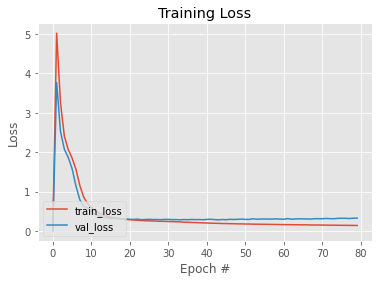

In [ ]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, loss, label="train_loss")
plt.plot(N, val_Loss, label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("losses.png")

In [ ]:
print(loss)

In [ ]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  462336    
_________________________________________________________________
decoder (Decoder)            multiple                  594944    
_________________________________________________________________
dense_32 (Dense)             multiple                  66306     
Total params: 1,123,586
Trainable params: 1,123,586
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(dir(transformer.layers[2]))

['_TF_MODULE_IGNORED_PROPERTIES', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_activity_regularizer', '_add_inbound_node', '_add_variable_with_custom_getter', '_autocast', '_call_accepts_kwargs', '_call_arg_was_passed', '_call_fn_args', '_callable_losses', '_checkpoint_dependencies', '_clear_losses', '_collect_input_masks', '_compute_dtype', '_deferred_dependencies', '_dtype', '_dtype_defaulted_to_floatx', '_dtype_policy', '_dynamic', '_eager_add_metric', '_eager_losses', '_expects_mask_arg', '_expects_training_arg', '_flatten', '_gather_children_attribute', '_gather_saveables_for_checkpoint', '_get_call_arg_value', '_get_existing_metric', '_get_node_attribute_at_index', '_get_t

### To be done


* Design and run two/three experiments

* Add Tokenzed -> Tensor function
* Add Tensor -> MIDI function(WIthout the expressive features)

* Add tensorboard visualisation for embedding layer




In [ ]:
ls

checkpoints/  sample_data/
